In [1]:
import sys
sys.path.append('lib/')
sys.path.append('lib/src/')
sys.path.append('lib/src/pythae')
import torch
import numpy as np
from torch import nn
import os
from matplotlib import pyplot as plt
import lightning as L
from sklearn.decomposition import PCA

from lib.src.pythae.models import VAE
from lib.scripts.utils import Encoder_Chairs,Decoder_Chairs, My_Dataset, My_MaskedDataset, make_batched_masks
from lib.src.pythae.models.vae import VAEConfig
from lib.src.pythae.trainers import BaseTrainerConfig
from lib.src.pythae.pipelines.training import TrainingPipeline
from lib.src.pythae.samplers.normal_sampling import NormalSampler
from lib.src.pythae.samplers.manifold_sampler import RHVAESampler

sys.path.append('diffusion/stable_diffusion/')
sys.path.append('diffusion/stable_diffusion/model/')
from diffusion.stable_diffusion.latent_diffusion import LatentDiffusion, DiffusionWrapper, MyLatentDiffusion, LitLDM
from diffusion.stable_diffusion.model.autoencoder import Autoencoder
from diffusion.stable_diffusion.model.clip_embedder import CLIPTextEmbedder
from diffusion.stable_diffusion.model.unet import UNetModel, _test_time_embeddings
from diffusion.stable_diffusion.sampler.ddim import DDIMSampler

%reload_ext autoreload
%autoreload 2

In [2]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
train_data = torch.load(os.path.join('lib/my_data/sprites/Sprites_train.pt'))[:-1000, -1, :, :, :].to(device) #only keeping the last frame of each sequence
eval_data = torch.load(os.path.join('lib/my_data/sprites/Sprites_train.pt'), map_location="cpu")[-1000:, -1, :, :, :].to(device)
#test_data = torch.load(os.path.join('lib/my_data/sprites/Sprites_test.pt'), map_location="cpu")[:, -1, :, :, :].to(device)
print(train_data.shape)
train_data = train_data.permute(0, 3, 1, 2)
eval_data = eval_data.permute(0, 3, 1, 2)
#test_data = test_data.permute(0, 3, 1, 2)
print(train_data.shape)

train_seq_mask = torch.ones(train_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
eval_seq_mask = torch.ones(eval_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
#test_seq_mask = torch.ones(test_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
train_pix_mask = torch.ones_like(train_data, requires_grad=False).type(torch.bool).to(device)
eval_pix_mask = torch.ones_like(eval_data, requires_grad=False).type(torch.bool).to(device)
#test_pix_mask = torch.ones_like(test_data, requires_grad=False).type(torch.bool).to(device)

train_dataset = My_MaskedDataset(train_data, train_seq_mask, train_pix_mask)
eval_dataset = My_MaskedDataset(eval_data, eval_seq_mask, eval_pix_mask)
#test_dataset = My_MaskedDataset(test_data, test_seq_mask, test_pix_mask)

torch.Size([8000, 64, 64, 3])
torch.Size([8000, 3, 64, 64])


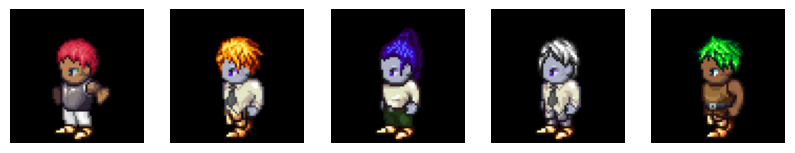

In [12]:
#check
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(train_dataset[i][0].data.cpu().permute(1, 2, 0))
    plt.axis('off')
plt.show()

In [14]:
input_dim = (3, 64, 64)
f = 32 #subsampling factor
latent_dim = 3* (64 // f) * (64 // f)
print('Latent dim:', latent_dim)

training_config = BaseTrainerConfig(output_dir='my_model',
num_epochs=100,
learning_rate=1e-3,
per_device_train_batch_size=200,
per_device_eval_batch_size=200,
train_dataloader_num_workers=2,
eval_dataloader_num_workers=2,
steps_saving=50,
optimizer_cls="AdamW",
optimizer_params={"weight_decay": 0.05, "betas": (0.91, 0.995)},
scheduler_cls="ReduceLROnPlateau",
scheduler_params={"patience": 5, "factor": 0.5})

device = 'cuda'
vae = VAE.load_from_folder('pre-trained_vae/VAE_training_2024-05-30_17-33-43-latdim12/final_model').to(device)
vae.eval()


Latent dim: 12


VAE(
  (decoder): Decoder_Chairs(
    (fc): Linear(in_features=12, out_features=2048, bias=True)
    (layers): Sequential(
      (0): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (2): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (3): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
  

In [16]:

def load_config_unet(config):
    return UNetModel(
        in_channels=config['in_channels'],
        out_channels=config['out_channels'],
        channels=config['channels'],
        n_res_blocks=config['n_res_blocks'],
        attention_levels=config['attention_levels'],
        channel_multipliers=config['channel_multipliers'],
        n_heads=config['n_heads'],
    )


######## UNET #######
# in_channels = 3
# out_channels = 3
# channels = 64
# n_res_blocks = 2
# attention_levels = [3]
# channel_multipliers = (1, 2, 2, 4)
# n_heads = 2

in_channels = 3
out_channels = 3
channels = 64
n_res_blocks = 4
attention_levels = [0]
channel_multipliers = [1]
n_heads = 4

unet_config = {
    'in_channels': in_channels,
    'out_channels': out_channels,
    'channels': channels,
    'n_res_blocks': n_res_blocks,
    'attention_levels': attention_levels,
    'channel_multipliers': channel_multipliers,
    'n_heads': n_heads,
}

unet = load_config_unet(unet_config)

h, w = 64//f, 64//f


z = torch.randn(1, 3, h, w)
print("Shape of input U-NET: ", z.shape)
empty_prompt_embed = None
print("Shape of output: ", unet(z, torch.tensor([10]), empty_prompt_embed).shape)
print("Number of trainable params: ", sum(p.numel() for p in unet.parameters() if p.requires_grad))

latent_scaling_factor = 1
n_steps = 1000
linear_start =  0.00085
linear_end = 0.05


latent_diffusion = MyLatentDiffusion(unet, None, latent_scaling_factor, n_steps, linear_start, linear_end)
print("Number of trainable params (should not change): ", sum(p.numel() for p in latent_diffusion.parameters() if p.requires_grad))

Shape of input U-NET:  torch.Size([1, 3, 2, 2])
Shape of output:  torch.Size([1, 3, 2, 2])
Number of trainable params:  2223043
Number of trainable params (should not change):  2223043


In [17]:
n_steps = 1000
linear_start =  0.00085
linear_end = 0.012
latent_scaling_factor = 1
lr = 6*1e-4

vae = vae.to('cuda')
latent_diffusion = MyLatentDiffusion(unet, None, latent_scaling_factor, n_steps, linear_start, linear_end)
model = LitLDM(latent_diffusion, vae, latent_dim = latent_dim, lr = lr).to('cuda')



train_loader = torch.utils.data.DataLoader(train_data, batch_size=400, num_workers = 12)
val_loader = torch.utils.data.DataLoader(eval_data, batch_size=400, num_workers = 12)

# trainer = L.Trainer(max_epochs=100,
#                      default_root_dir='ldm', accelerator = 'gpu', 
#                      check_val_every_n_epoch=5)



# trainer.fit(model, train_loader, val_loader)

model = LitLDM.load_from_checkpoint('ldm/lightning_logs/version_30/checkpoints/epoch=44-step=900.ckpt', ldm = latent_diffusion, vae = vae, latent_dim = latent_dim).to('cuda')

In [18]:
vae = vae.to('cuda')
model = model.to('cuda')
trainer = L.Trainer()
trainer.validate(model, val_loader)
trainer.validate(model, train_loader)

/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /users/eleves-a/2020/meilame.tayebjee/miniconda3/lib ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A2000 12GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss             2.014204740524292
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            2.1788511276245117
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 2.1788511276245117}]

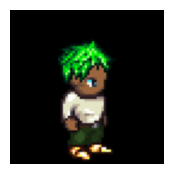

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


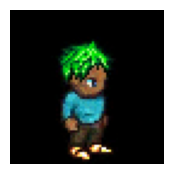

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1.1826, grad_fn=<MseLossBackward0>)
tensor(0.5725, grad_fn=<MseLossBackward0>)
Coming from =  tensor(1.8182)
Distance parcourue : tensor(1.6247, grad_fn=<MseLossBackward0>)


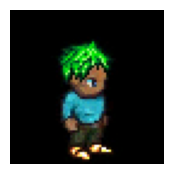

In [20]:
#Test en tant que denoiser

x= next(iter(val_loader))[10]
vae = vae.to('cpu')
model = model.to('cpu')

plt.figure(figsize=(2, 2))
plt.imshow(x.permute(1, 2, 0))
plt.axis('off')
plt.show()
#z = model.ldm.autoencoder_encode(x)
z = vae.encoder(x).embedding



t = torch.tensor([250])


noise = torch.randn_like(z)
noisy_z = model.ldm.add_noise(z, noise, t).float().reshape(-1, model.c, model.h, model.w)

noisy_x = vae.decoder(noisy_z.reshape(-1, latent_dim)).reconstruction

plt.figure(figsize=(2, 2))
plt.imshow(noisy_x[0].detach().permute(1, 2, 0))
plt.axis('off')
plt.show()

noise_pred= model.ldm(noisy_z, t)

print(nn.MSELoss(reduction = 'sum')(noise_pred.reshape(1, latent_dim), noise))

#sampler = DDIMSampler(model.ldm, n_steps = 8)
# sampler = DDPMSampler(model.ldm)
# z_pred, _, _ = sampler.sample(shape=(1, 3, 8, 8), x_last = noisy_z, cond=None)


z_pred = (noisy_z - (1- model.ldm.alpha_bar[t]) ** 0.5 * noise_pred) / (model.ldm.alpha_bar[t] ** 0.5)
z_pred = z_pred.reshape(-1, latent_dim).float()

#z_pred = z 

print(nn.MSELoss(reduction = 'sum')(z_pred, z.reshape(-1, latent_dim)))
print('Coming from = ', nn.MSELoss(reduction = 'sum')(z, noisy_z.reshape(-1, latent_dim)))
print('Distance parcourue :', nn.MSELoss(reduction = 'sum')(z_pred, noisy_z.reshape(-1, latent_dim)))

#x_pred = model.ldm.autoencoder_decode(z_pred)
x_pred = vae.decoder(z_pred).reconstruction

plt.figure(figsize=(2, 2))
plt.imshow(x_pred[0].detach().permute(1, 2, 0))
plt.axis('off')
plt.show()






Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


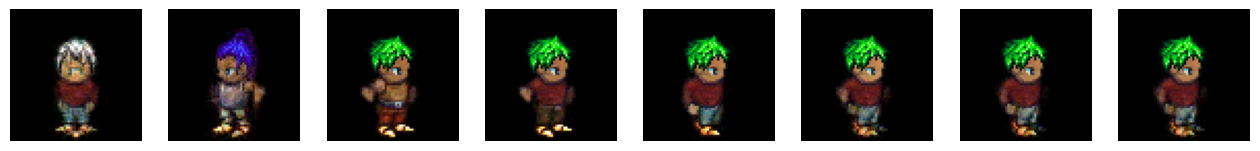

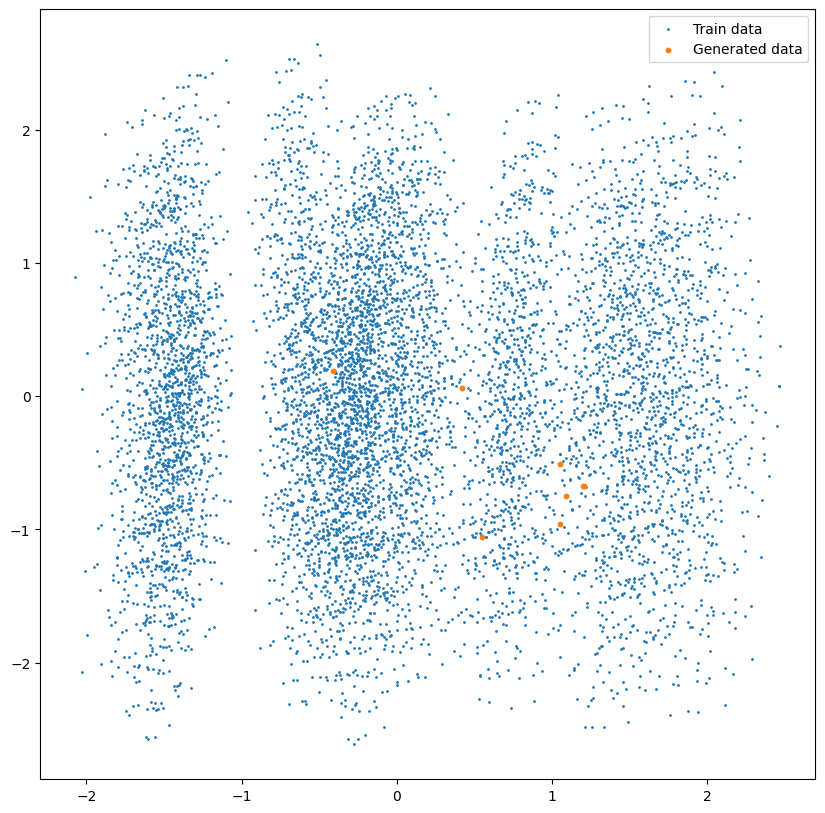

In [20]:
#Generation



vae = vae.to('cpu')
model = model.to('cpu')
sampler = DDIMSampler(model.ldm, n_steps = 8, ddim_eta  = 1)
#sampler = DDPMSampler(model.ldm)

start = torch.randn(1, model.c, model.h, model.w).to('cpu')
#z, all_z, all_pred_z0 = sampler.sample(shape=(1, 3, 8, 8), x_last = start, cond=None,selected_time_steps = [i* 999 // 7 for i in range(8)])
z, all_z, all_pred_z0 = sampler.sample(shape=(1, model.c, model.h, model.w), x_last = start, cond=None)
z = z.reshape(-1, latent_dim).float()
x = vae.decoder(z).reconstruction.reshape(-1, 3, 64, 64)


all_z = all_z.squeeze(1).reshape(-1, latent_dim)
all_pred_z0 = all_pred_z0.squeeze(1).reshape(-1, latent_dim)

all_x = vae.decoder(all_z).reconstruction.reshape(-1, 3, 64, 64)
all_pred_x0 = vae.decoder(all_pred_z0).reconstruction.reshape(-1, 3, 64, 64)




plt.figure(figsize=(16, 24))
for i in range(8):
    plt.subplot(1, 8, i+1)
    #plt.imshow(all_x[12*i].detach().permute(1, 2, 0))
    plt.imshow(all_x[i].detach().permute(1, 2, 0))
    plt.axis('off')
plt.show()

# plt.figure(figsize=(16, 24))
# for i in range(8):
#     plt.subplot(1, 8, i+1)
#     plt.imshow(all_pred_x0[i].detach().permute(1, 2, 0))
#     plt.axis('off')
# plt.show()


train_embeddings = vae.encoder.to('cpu')(train_dataset.data).embedding
start = start.reshape(-1, latent_dim).float()
pca = PCA(n_components=2)
train_pca = pca.fit_transform(train_embeddings.detach().numpy())

all_z_pca = pca.transform(all_z.detach().numpy())

plt.figure(figsize=(10, 10))
plt.scatter(train_pca[:, 0], train_pca[:, 1], label='Train data', s= 1)
plt.scatter(all_z_pca[:, 0], all_z_pca[:, 1], s = 10, label='Generated data')
plt.legend()
plt.show()


# plt.figure(figsize=(10, 10))
# for i in range(25):
#     plt.subplot(5, 5, i+1)
#     plt.imshow(x[i].detach().permute(1, 2, 0))
#     plt.axis('off')
# plt.show()


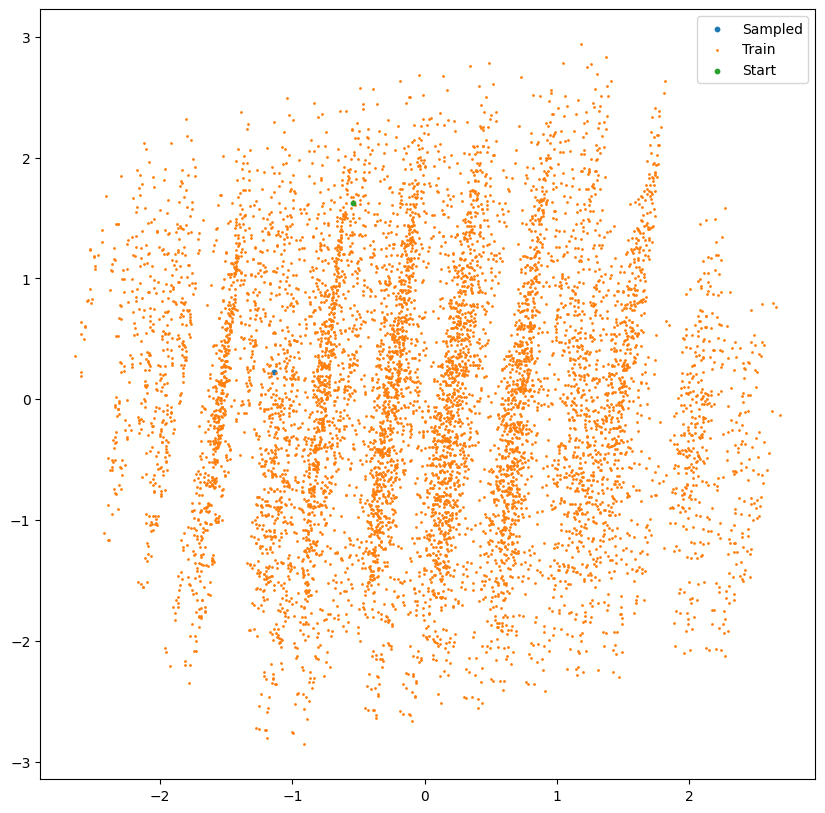

In [46]:
train_embeddings = vae.encoder.to('cpu')(train_dataset.data).embedding
start = start.reshape(-1, latent_dim).float()
pca = PCA(n_components=2)
train_pca = pca.fit_transform(train_embeddings.detach().numpy())
z_pca = pca.transform(z.detach().numpy())
start_pca = pca.transform(start.detach().numpy())


plt.figure(figsize=(10, 10))
plt.scatter(z_pca[:, 0], z_pca[:, 1], s=10, label = "Sampled")
plt.scatter(train_pca[:, 0], train_pca[:, 1], s=1, label = "Train")
plt.scatter(start_pca[:, 0], start_pca[:, 1], s=10, label = "Start")
plt.legend()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


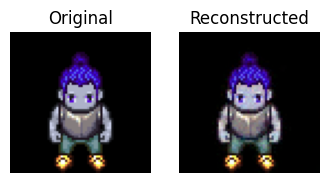

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


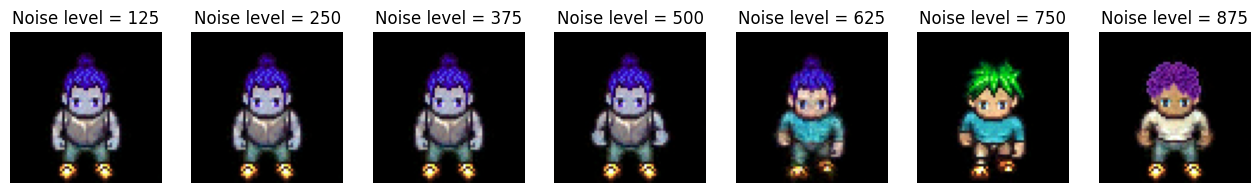

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 12])) that is different to the input size (torch.Size([12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0

tensor(2.4599)
Baseline2:  tensor(4.6450)
Baseline3:  tensor(4.7903)
tensor(2.4417)
Baseline2:  tensor(2.0384)
Baseline3:  tensor(4.6693)
tensor(5.1693)
Baseline2:  tensor(0.9022)
Baseline3:  tensor(4.9126)
tensor(4.9100)
Baseline2:  tensor(0.4963)
Baseline3:  tensor(5.3148)
tensor(4.8503)
Baseline2:  tensor(0.3794)
Baseline3:  tensor(5.4326)
tensor(5.4528)
Baseline2:  tensor(0.0774)
Baseline3:  tensor(5.8438)
tensor(5.8980)
Baseline2:  tensor(0.)
Baseline3:  tensor(5.8980)


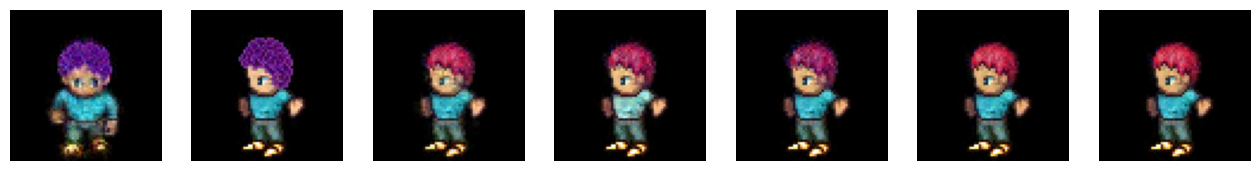

In [27]:
x = next(iter(val_loader))[3]
vae = vae.to('cpu')
model = model.to('cpu')
z_orig = vae.encoder(x).embedding.float()
x_rec = vae.decoder(z_orig).reconstruction.reshape(3, 64, 64).detach()
plt.figure(figsize=(4, 4))
plt.subplot(1, 2, 1)
plt.title('Original')
plt.imshow(x.permute(1, 2, 0))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Reconstructed')
plt.imshow(x_rec.permute(1, 2, 0))
plt.axis('off')
plt.show()

all_noisy_z = [z_orig]
plt.figure(figsize=(16, 24))
ts = [125*i for i in range(1, 8)]
for i in range(7):
    noise = torch.randn_like(z_orig)
    prev_z = all_noisy_z[-1]

    #noisy_z = model.ldm.add_noise(prev_z, noise, torch.tensor([125])).float()
    #noisy_z = model.ldm.add_noise(z_orig, noise, torch.tensor([ts[i]])).float()

    if i> 0:
        noisy_z = model.ldm.sequential_diffusion(prev_z, ts[i-1], ts[i], noise).float()
    else:
        noisy_z = model.ldm.sequential_diffusion(prev_z, 0, ts[i], noise).float()

    all_noisy_z.append(noisy_z)

    noisy_x = vae.decoder(noisy_z.reshape(-1, latent_dim)).reconstruction.reshape(3, 64, 64).detach()

    plt.subplot(1, 7, i+1)
    plt.title('Noise level = ' + str(ts[i]))
    plt.imshow(noisy_x.permute(1, 2, 0))
    plt.axis('off')
plt.show()

sampler = DDIMSampler(model.ldm, n_steps = 7, ddim_eta = 1)
sampler.time_steps = ts
#sampler = DDPMSampler(model.ldm)


start = noisy_z.reshape(-1, model.c, model.h, model.w)
#z, all_z, all_pred_z0 = sampler.sample(shape=(1, 3, 8, 8), x_last = start, cond=None, selected_time_steps=[i* 999 // 7 +1 for i in range(8)], temperature = 0)
z, all_z, all_pred_z0 = sampler.sample(shape=(1, 3, 8, 8), x_last = start, cond=None, temperature = 0.2)
z = z.reshape(-1, latent_dim).float()
x = vae.decoder(z).reconstruction.reshape(-1, 3, 64, 64)


all_z = all_z.squeeze(1).reshape(-1, latent_dim)

all_x = vae.decoder(all_z).reconstruction.reshape(-1, 3, 64, 64).detach()
plt.figure(figsize=(16, 24))
for i in range(7):
    plt.subplot(1, 7, i+1)
    #plt.title('Pred level ' + str(ts[-i-2]) + '|' + str(ts[-i-1]))
    plt.imshow(all_x[i].permute(1, 2, 0))
    plt.axis('off')
    z_pred = all_z[i]
    z_target = all_noisy_z[-i-2].reshape(-1, latent_dim)
    print(nn.MSELoss(reduction = 'sum')(z_pred, z_target))
    print('Baseline2: ', nn.MSELoss(reduction = 'sum')(z_orig, z_target))
    print('Baseline3: ', nn.MSELoss(reduction = 'sum')(z_pred, z_orig))
plt.show()

[0, 142, 284, 426, 568, 710, 852, 994]


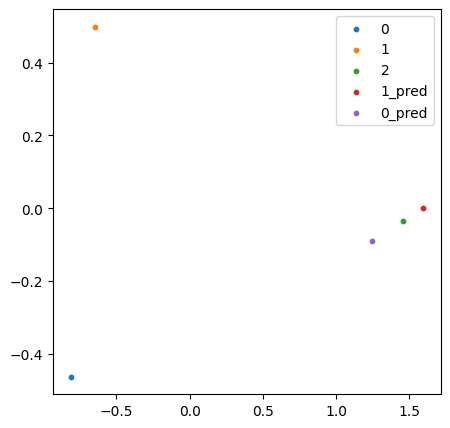

In [26]:
x0 = next(iter(val_loader))[100]
z0 = vae.encoder(x0).embedding.float()
# z1 = model.ldm.add_noise(z0, torch.randn_like(z0), torch.tensor([124])).float()
# z2 = model.ldm.sequential_diffusion(z1, 125, 250, torch.randn_like(z0)).float()


sampler = DDIMSampler(model.ldm, n_steps = 7, ddim_eta = 1)
sampler.time_steps = [i-1 for i in sampler.time_steps]
print(sampler.time_steps)
z1 = sampler.q_sample(x0 = z0, index=1)
z2 = sampler.q_sample(x0 = z0, index=2)



z_full = torch.cat([z0, z1, z2], dim = 0)
pca = PCA(n_components=2)
z_pca = pca.fit_transform(z_full.detach().numpy())



z1_pred, _, _ = sampler.p_sample(x=z2.reshape(-1, model.c, model.h, model.w), c=None, t= torch.tensor([284]), step = 284, index = 2, temperature = 1)
z1_pred = z1_pred.reshape(-1, latent_dim).float()
z1_pred_pca = pca.transform(z1_pred.detach().numpy())

z0_pred, _, _ = sampler.p_sample(x=z1_pred.reshape(-1, model.c, model.h, model.w), c=None, t= torch.tensor([142]), step = 142, index = 1, temperature = 1)
z0_pred = z0_pred.reshape(-1, latent_dim).float()
z0_pred_pca = pca.transform(z0_pred.detach().numpy())

plt.figure(figsize=(5, 5))
for i in range(3):
    plt.scatter(z_pca[i, 0], z_pca[i, 1], s=10, label = r'{}'.format(i))

plt.scatter(z1_pred_pca[0, 0], z1_pred_pca[0, 1], s=10, label = '1_pred')
plt.scatter(z0_pred_pca[0, 0], z0_pred_pca[0, 1], s=10, label = '0_pred')
plt.legend()
plt.show()


In [29]:
torch.random.manual_seed(0)
x0 = next(iter(val_loader))[100]
z0 = vae.encoder(x0).embedding.float()

In [97]:
torch.random.manual_seed(0)
index = 1
sampler = DDIMSampler(model.ldm, n_steps = 7, ddim_eta = 1)
print(sampler.time_steps)

noise = torch.randn_like(z0)
z1 = sampler.q_sample(x0 = z0, index=index, noise = noise)
print(((z1 - z0)**2).sum())


z1_check = model.ldm.sequential_diffusion(z0, t1 = 0, t2 = 143, noise = noise)

z1_check_ldm = model.ldm.add_noise(z0, noise = noise, t = torch.tensor([143]))

print(((z1 - z1_check)**2).sum())
print(((z1 - z1_check_ldm)**2).sum())


print('coeff x ddim ', sampler.ddim_alpha_sqrt[index])
print('coeff noise ddim ', sampler.ddim_sqrt_one_minus_alpha[index] )

[  1 143 285 427 569 711 853 995]
tensor(2.4732)
coeff x  tensor([[0.9152]], dtype=torch.float64)
coeff noise  tensor([[0.4030]], dtype=torch.float64)
coeff x ldm  tensor([[0.9152]], dtype=torch.float64)
coeff noise ldm  tensor([[0.4030]])
tensor(2.8731e-14, dtype=torch.float64)
tensor(2.7609e-14, dtype=torch.float64)
coeff x ddim  tensor(0.9152)
coeff noise ddim  tensor(0.4030)


In [101]:
torch.random.manual_seed(0)
noise = torch.randn_like(z1)
index = 2
z2_ddim = sampler.q_sample(x0 = z1, index=index, noise = noise)
z2_check = model.ldm.sequential_diffusion(z1, t1 = 143, t2 = 285, noise = noise)
z2_ldm = model.ldm.add_noise(z1, noise = noise, t = torch.tensor([285]))

print(((z2_ddim - z2_check)**2).sum())
print(((z2_ddim - z2_ldm)**2).sum())

print('coeff x ddim ', sampler.ddim_alpha_sqrt[index])
print('coeff noise ddim ', sampler.ddim_sqrt_one_minus_alpha[index] )


coeff x  tensor([[0.8581]], dtype=torch.float64)
coeff noise  tensor([[0.5135]], dtype=torch.float64)
coeff x ldm  tensor([[0.7847]], dtype=torch.float64)
coeff noise ldm  tensor([[0.6199]])
tensor(0.1737, dtype=torch.float64)
tensor(4.3845e-15, dtype=torch.float64)
coeff x ddim  tensor(0.7847)
coeff noise ddim  tensor(0.6199)


In [70]:
from torchmetrics.image.fid import FrechetInceptionDistance


model = model.to('cpu')
vae = vae.to('cpu')
sampler = DDIMSampler(model.ldm, n_steps = 7, ddim_eta = 1)
start = torch.randn(1000, model.c, model.h, model.w)
fake_images, _, _ = sampler.sample(shape=(1000, model.c, model.h, model.w), x_last = start, cond=None, temperature = 1)

rand_indxes = torch.randint(0, 8000, (1000,))
real_images = vae.encoder(train_data[rand_indxes]).embedding.reshape(-1, model.c, model.h, model.w)

fid = FrechetInceptionDistance(normalize=True)
fid.update(real_images, real=True)
fid.update(fake_images, real=False)

print(fid.compute())


tensor(7.7321)
